# Exploratory Data Analysis: Knuth Miles Dataset

This notebook analyzes the Knuth Miles dataset, which contains information about 128 US and Canadian cities, including their geographic coordinates, populations, and pairwise distances. The dataset represents a transportation network from 1949.

## Research Questions
1. What is the geographic distribution of cities?
2. How are populations distributed across cities?
3. What are the structural properties of the transportation network?
4. Which cities are most central in the network?
5. Are there any natural clusters or communities in the network?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set visualization style
#plt.style.use('seaborn')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## Data Loading and Preprocessing

In [8]:
# Load the data
cities = np.genfromtxt('../data/cities.csv', delimiter=',', dtype=str, skip_header=1)
distances = np.genfromtxt('../data/distances.csv', delimiter=',')

# Convert cities data to structured array
city_names = cities[:, 0]
state_names = cities[:, 1]
latitudes = cities[:, 2].astype(float)
longitudes = cities[:, 3].astype(float)
populations = cities[:, 4].astype(int)

print(f"Number of cities: {len(city_names)}")
print(f"Distance matrix shape: {distances.shape}")

Number of cities: 128
Distance matrix shape: (128, 128)


## 1. Geographic Distribution Analysis

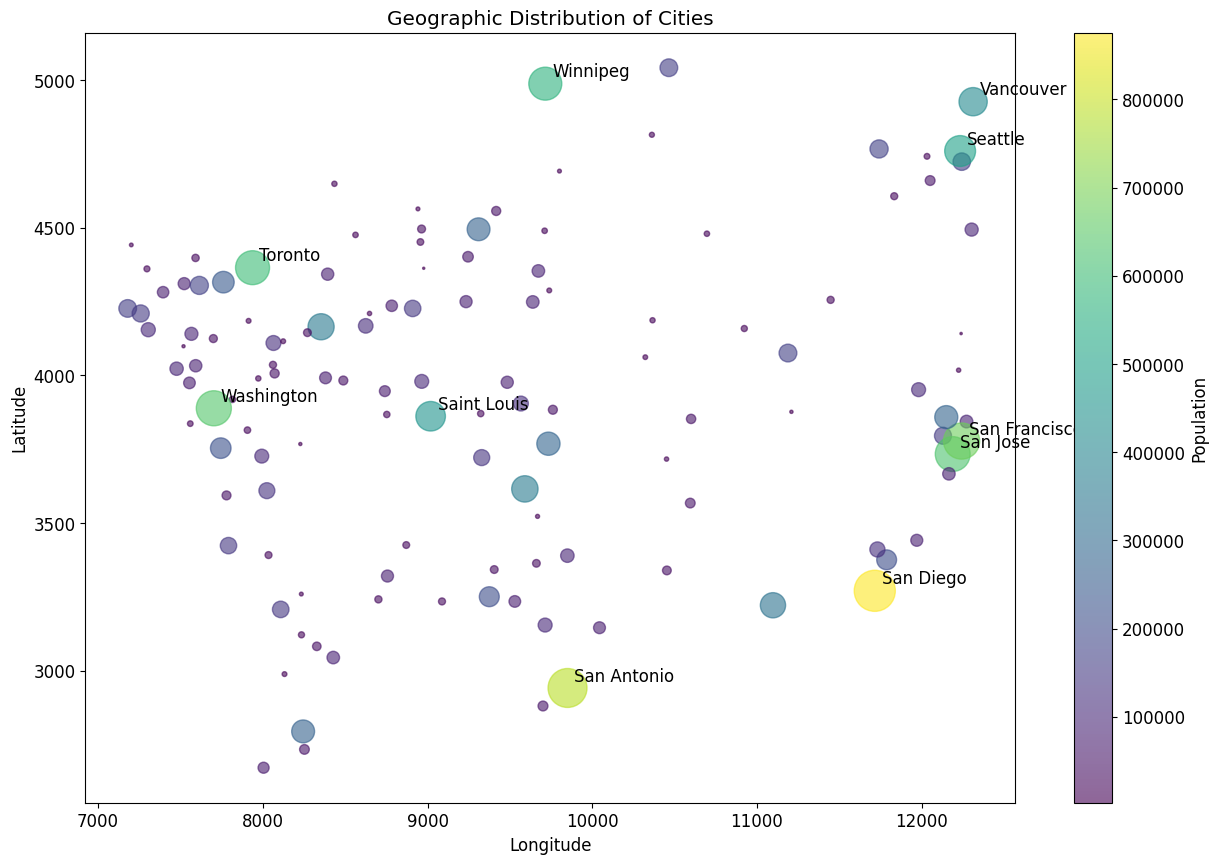

In [9]:
plt.figure(figsize=(15, 10))
plt.scatter(longitudes, latitudes, s=populations/1000, alpha=0.6, c=populations, cmap='viridis')
plt.colorbar(label='Population')
plt.title('Geographic Distribution of Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add city labels for major cities (top 10 by population)
top_cities_idx = np.argsort(populations)[-10:]
for idx in top_cities_idx:
    plt.annotate(city_names[idx], 
                (longitudes[idx], latitudes[idx]),
                xytext=(5, 5), textcoords='offset points')
plt.show()

## 2. Population Analysis

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Population distribution
sns.histplot(populations, bins=30, ax=ax1)
ax1.set_title('Population Distribution')
ax1.set_xlabel('Population')
ax1.set_ylabel('Count')

# Log-transformed population distribution
sns.histplot(np.log10(populations), bins=30, ax=ax2)
ax2.set_title('Log-transformed Population Distribution')
ax2.set_xlabel('log10(Population)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Population statistics
print(f"Population Statistics:")
print(f"Mean: {np.mean(populations):,.0f}")
print(f"Median: {np.median(populations):,.0f}")
print(f"Std Dev: {np.std(populations):,.0f}")
print(f"Min: {np.min(populations):,.0f}")
print(f"Max: {np.max(populations):,.0f}")

Population Statistics:
Mean: 119,880
Median: 67,812
Std Dev: 166,785
Min: 2,521
Max: 875,538


## 3. Network Analysis

In [11]:
# Create network graph
G = nx.Graph()

# Add nodes with attributes
for i, city in enumerate(city_names):
    G.add_node(city, 
               population=populations[i],
               latitude=latitudes[i],
               longitude=longitudes[i])

# Add edges (only for distances less than 500 miles)
for i in range(len(city_names)):
    for j in range(i+1, len(city_names)):
        if distances[i,j] < 500:
            G.add_edge(city_names[i], city_names[j], weight=distances[i,j])

# Calculate network metrics
print(f"Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
print(f"Density: {nx.density(G):.4f}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")
print(f"Average shortest path length: {nx.average_shortest_path_length(G):.2f}")

Network Statistics:
Number of nodes: 120
Number of edges: 6077
Average degree: 101.28
Density: 0.8511
Average clustering coefficient: 0.8408
Average shortest path length: 1.15


## 4. Centrality Analysis

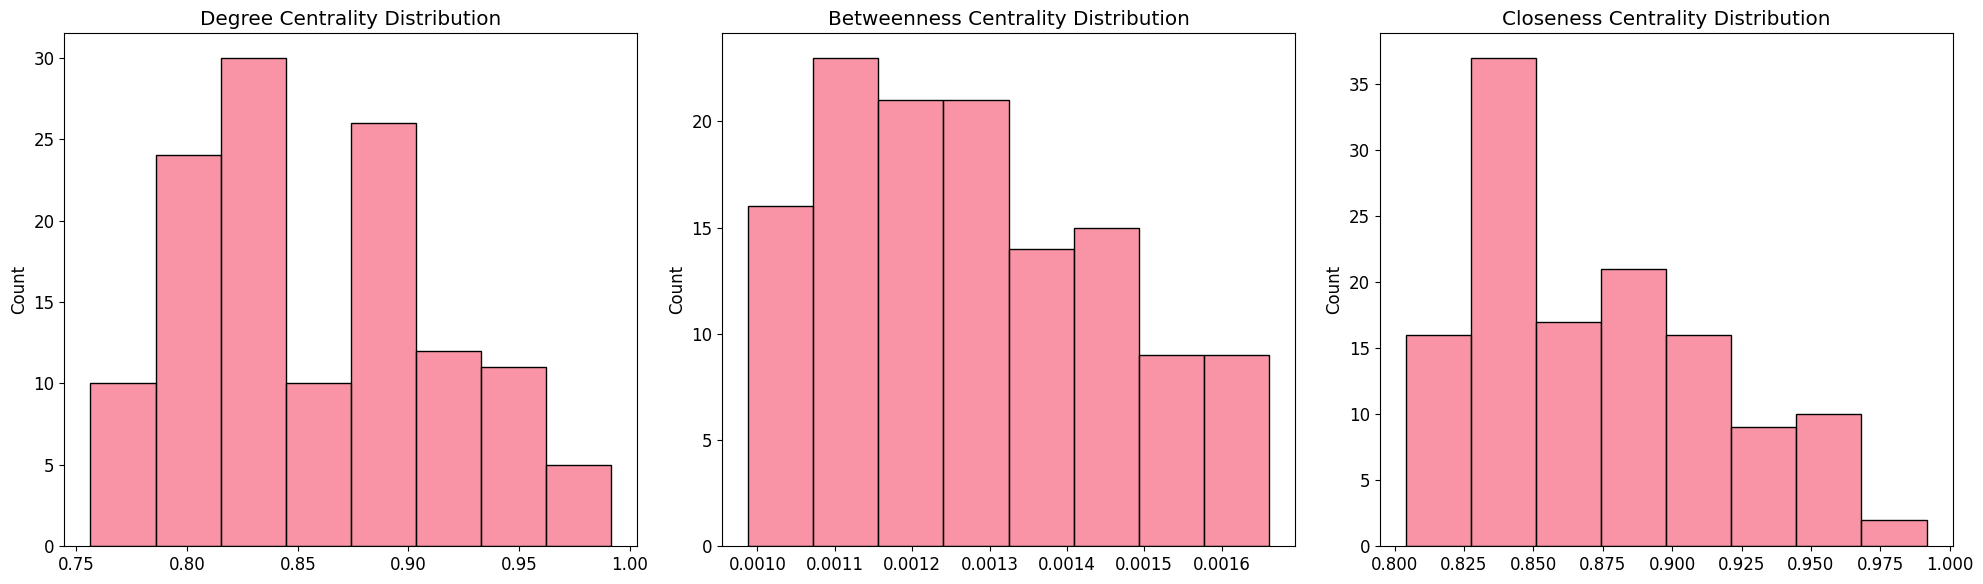


Top 5 cities by Degree Centrality:
Youngstown: 0.9916
Wilmington: 0.9832
Wilmington: 0.9832
Yankton: 0.9748
Yakima: 0.9664

Top 5 cities by Betweenness Centrality:
Youngstown: 0.0017
Yankton: 0.0017
Yakima: 0.0016
Worcester: 0.0016
Wisconsin Dells: 0.0016

Top 5 cities by Closeness Centrality:
Youngstown: 0.9917
Yankton: 0.9754
Yakima: 0.9675
Wilmington: 0.9675
Wilmington: 0.9675


In [12]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Create DataFrame for centrality measures
centrality_data = []
for city in city_names:
    centrality_data.append({
        'City': city,
        'Degree': degree_centrality[city],
        'Betweenness': betweenness_centrality[city],
        'Closeness': closeness_centrality[city]
    })

# Plot centrality distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot([d['Degree'] for d in centrality_data], ax=ax1)
ax1.set_title('Degree Centrality Distribution')

sns.histplot([d['Betweenness'] for d in centrality_data], ax=ax2)
ax2.set_title('Betweenness Centrality Distribution')

sns.histplot([d['Closeness'] for d in centrality_data], ax=ax3)
ax3.set_title('Closeness Centrality Distribution')

plt.tight_layout()
plt.show()

# Print top 5 cities by each centrality measure
print("\nTop 5 cities by Degree Centrality:")
for city in sorted(centrality_data, key=lambda x: x['Degree'], reverse=True)[:5]:
    print(f"{city['City']}: {city['Degree']:.4f}")

print("\nTop 5 cities by Betweenness Centrality:")
for city in sorted(centrality_data, key=lambda x: x['Betweenness'], reverse=True)[:5]:
    print(f"{city['City']}: {city['Betweenness']:.4f}")

print("\nTop 5 cities by Closeness Centrality:")
for city in sorted(centrality_data, key=lambda x: x['Closeness'], reverse=True)[:5]:
    print(f"{city['City']}: {city['Closeness']:.4f}")

## 5. Community Detection

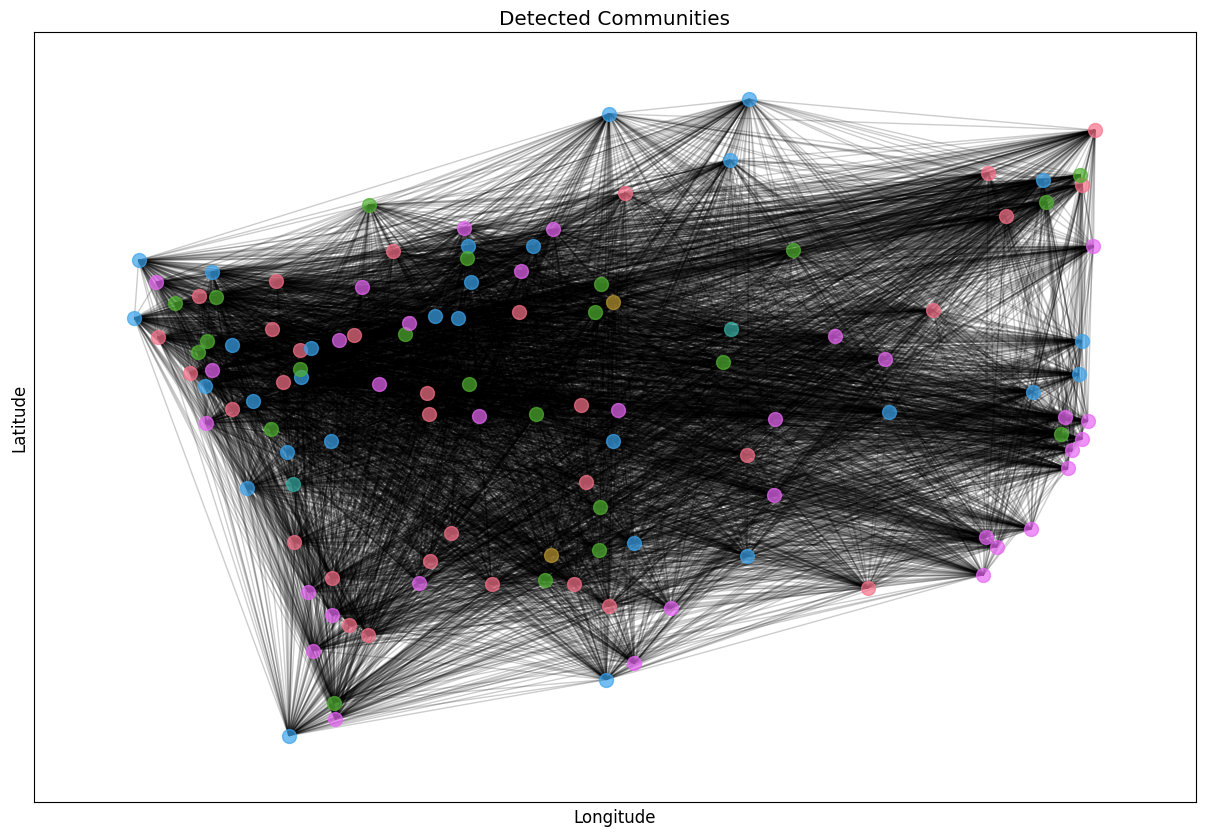

Number of communities: 12

Community 1 (1 cities):
Youngstown

Community 2 (1 cities):
Yankton

Community 3 (1 cities):
Yakima

Community 4 (1 cities):
Winston-Salem

Community 5 (18 cities):
Victoria, Watertown, Waukegan, Wausau, Weed, Wenatchee, West Palm Beach, Wheeling, Wichita, Wichita Falls, Williamson, Williamsport, Williston, Wilmington, Winchester, Winnipeg, Wisconsin Dells, Worcester

Community 6 (1 cities):
Waycross

Community 7 (31 cities):
Spokane, Sumter, Swainsboro, Tacoma, Tallahassee, Terre Haute, Toledo, Topeka, Toronto, Traverse City, Trenton, Trinidad, Tucson, Tulsa, Tupelo, Tuscaloosa, Twin Falls, Tyler, Uniontown, Utica, Valdosta, Valley City, Vancouver, Vicksburg, Vincennes, Waco, Walla Walla, Warren, Washington, Waterbury, Waterloo

Community 8 (1 cities):
Texarkana

Community 9 (21 cities):
Sault Sainte Marie, Schenectady, Scranton, Seattle, Sedalia, Seminole, Sheridan, Sherman, Shreveport, Sioux City, Sioux Falls, South Bend, Springfield, Staunton, Sterling, S

In [13]:
# Use Louvain method for community detection
communities = nx.community.louvain_communities(G)

# Plot communities
plt.figure(figsize=(15, 10))
pos = {city: (longitudes[i], latitudes[i]) for i, city in enumerate(city_names)}

# Draw nodes with community colors
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=list(community),
                          node_color=f'C{i}',
                          node_size=100,
                          alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

plt.title('Detected Communities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Print community sizes
print(f"Number of communities: {len(communities)}")
for i, community in enumerate(communities):
    print(f"\nCommunity {i+1} ({len(community)} cities):")
    print(", ".join(sorted(community))) 

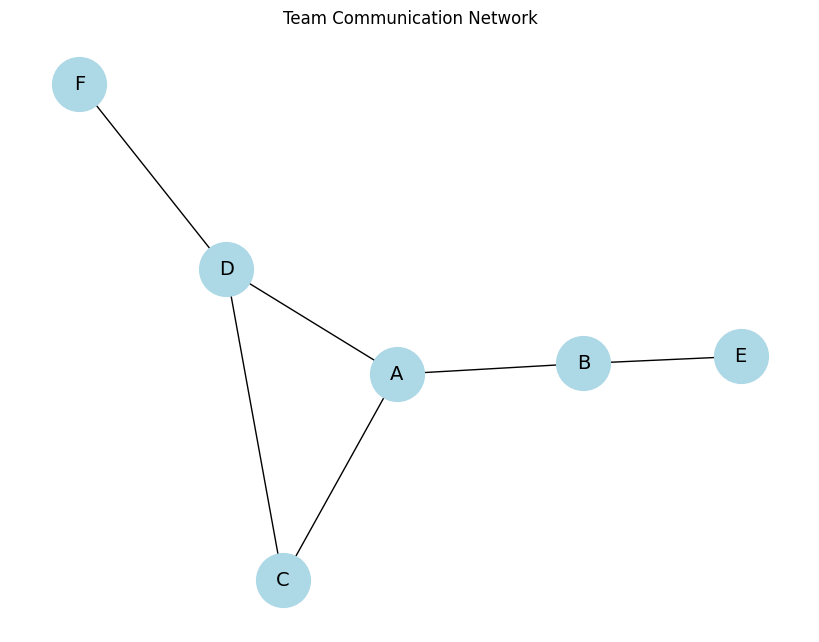

Node  Degree     Closeness  Betweenness  Eigenvector 
A     0.600      0.714      0.600        0.564       
B     0.400      0.556      0.400        0.296       
C     0.400      0.556      0.000        0.475       
D     0.600      0.625      0.400        0.545       
E     0.200      0.385      0.000        0.127       
F     0.200      0.417      0.000        0.234       


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.Graph()

# Add edges based on the scenario
edges = [
    ('A', 'B'), ('A', 'C'), ('A', 'D'),
    ('B', 'E'),
    ('C', 'D'),
    ('D', 'F')
]
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=14)
plt.title("Team Communication Network")
plt.show()

# Centrality Measures
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

# Display results
print(f"{'Node':<5} {'Degree':<10} {'Closeness':<10} {'Betweenness':<12} {'Eigenvector':<12}")
for node in G.nodes():
    print(f"{node:<5} {degree[node]:<10.3f} {closeness[node]:<10.3f} {betweenness[node]:<12.3f} {eigenvector[node]:<12.3f}")


In [3]:
type(G)

networkx.classes.graph.Graph

In [6]:
G.nodes()

NodeView(('A', 'B', 'C', 'D', 'E', 'F'))

In [7]:
G.edges()

EdgeView([('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'E'), ('C', 'D'), ('D', 'F')])

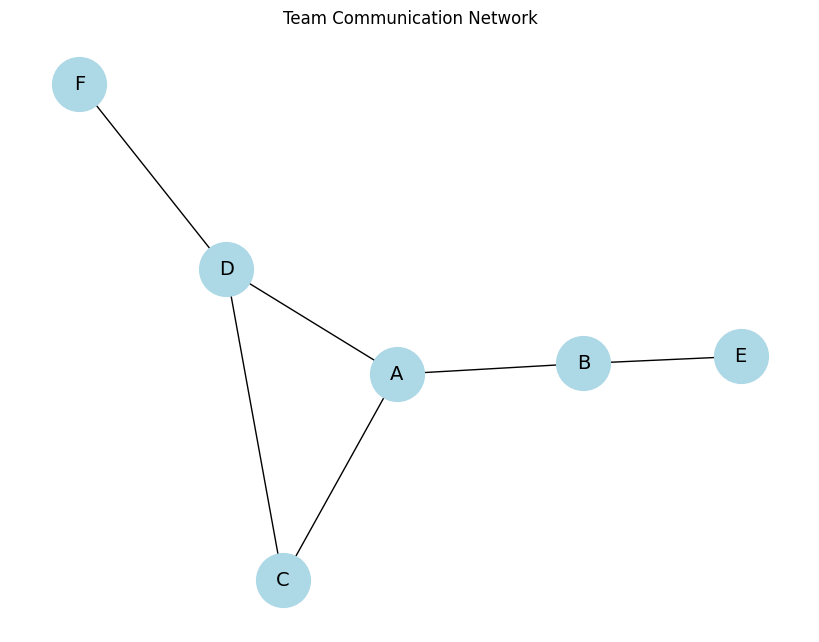

In [8]:
# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=14)
plt.title("Team Communication Network")
plt.show()

In [9]:
# Centrality Measures
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

# Display results
print(f"{'Node':<5} {'Degree':<10} {'Closeness':<10} {'Betweenness':<12} {'Eigenvector':<12}")
for node in G.nodes():
    print(f"{node:<5} {degree[node]:<10.3f} {closeness[node]:<10.3f} {betweenness[node]:<12.3f} {eigenvector[node]:<12.3f}")

Node  Degree     Closeness  Betweenness  Eigenvector 
A     0.600      0.714      0.600        0.564       
B     0.400      0.556      0.400        0.296       
C     0.400      0.556      0.000        0.475       
D     0.600      0.625      0.400        0.545       
E     0.200      0.385      0.000        0.127       
F     0.200      0.417      0.000        0.234       


In [10]:
closeness

{'A': 0.7142857142857143,
 'B': 0.5555555555555556,
 'C': 0.5555555555555556,
 'D': 0.625,
 'E': 0.38461538461538464,
 'F': 0.4166666666666667}